In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Generate a 3D tetrahedral mesh

This notebook shows how to mesh a 3D volume:

1. Load and visualize a volume
2. Apply image filters and segment image
3. Generate a 3D surface mesh
4. Visualize and export the mesh to other formats

In [2]:
import pyvista as pv
from skimage import filters
import numpy as np

### Load and vizualize the data

This example uses nanopore sample data from `nanomesh.data`.

If you want to use your own data, any numpy array can be passed to into a [`Volume`](https://nanomesh.readthedocs.io/en/latest/nanomesh.volume.html#nanomesh.volume.Volume) object. Data stored as `.npy` can be loaded using `Volume.load()`.

<IPython.core.display.Javascript object>


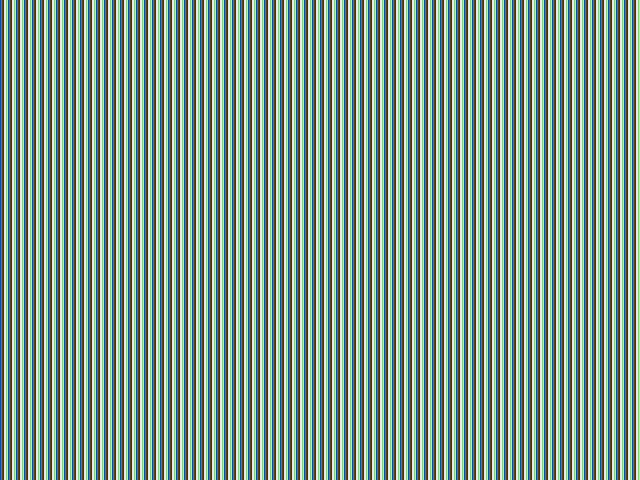

interactive(children=(IntSlider(value=99, description='index', max=199), RadioButtons(description='along', opt…

In [3]:
from nanomesh import Volume
from nanomesh.data import nanopores3d

data = nanopores3d()

vol = Volume(data)
vol.show_slice()

For this example, select a subvolume using `.select_subvolume` and downscale the image to keep the cpu times in check.

<IPython.core.display.Javascript object>


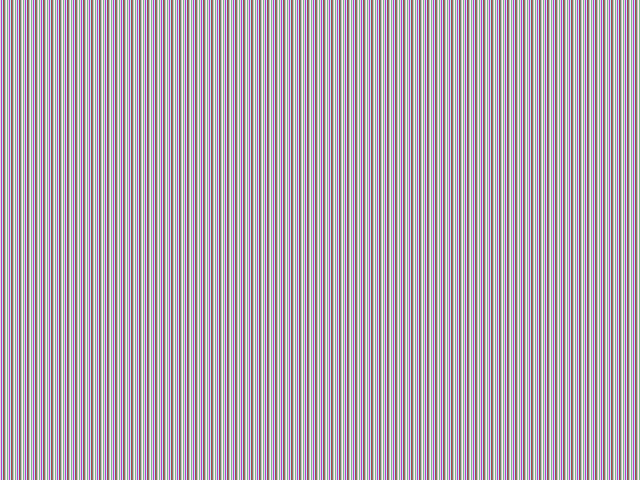

interactive(children=(IntSlider(value=24, description='index', max=49), RadioButtons(description='along', opti…

In [4]:
from skimage.transform import rescale

subvol = vol.select_subvolume(
    ys=(0,100),
    xs=(0,100),
).apply(rescale, scale=0.5)
subvol.show_slice()

Nanomesh makes use of [`itkwidgets`](https://github.com/InsightSoftwareConsortium/itkwidgets) to render the volumes.

In [5]:
subvol.show()

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

### Filter and segment the data

Image segmentation is a way to label the pixels of different regions of interest in an image. In this example, we are interested in separating the bulk material (Si) from the nanopores. In the image, the Si is bright, and the pores are dark.

First, we apply a [`gaussian filter`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) to smooth out some of the image noise to get a cleaner segmentation.

<IPython.core.display.Javascript object>


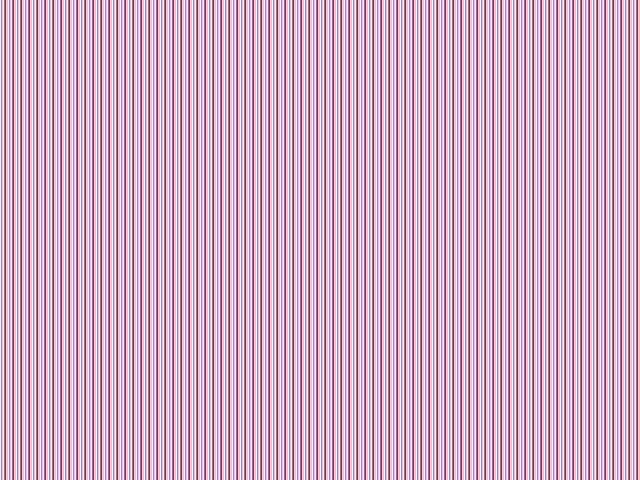

interactive(children=(IntSlider(value=12, description='index', max=49), RadioButtons(description='along', opti…

In [6]:
subvol_gauss = subvol.gaussian(sigma=1)
subvol_gauss.show_slice(x=12)

`scikit-image` contains a useful function to [try all threshold finders on the data](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold). These methods analyse the contrast histogram and try to find the optimal value to separate which parts of the image belong to each domain.

Since the function only works on a single slice, we first select a slice using the `.select_plane` method.

<IPython.core.display.Javascript object>


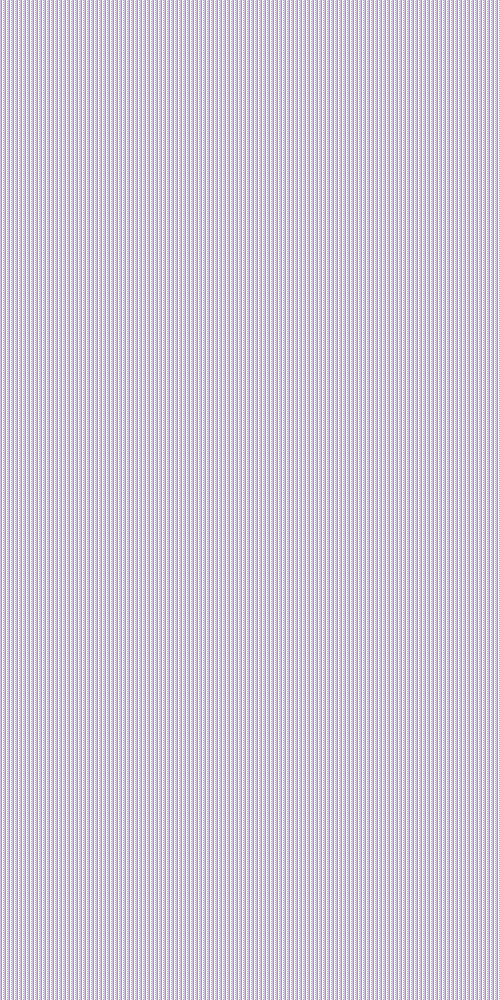

In [7]:
from skimage import filters

plane = subvol_gauss.select_plane(x=12)
plane.try_all_threshold(figsize=(5, 10))

We will use the `li` method, because it gives nice separation.

The threshold value is used to segment the image using [`np.digitize`](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html#numpy-digitize).

<IPython.core.display.Javascript object>


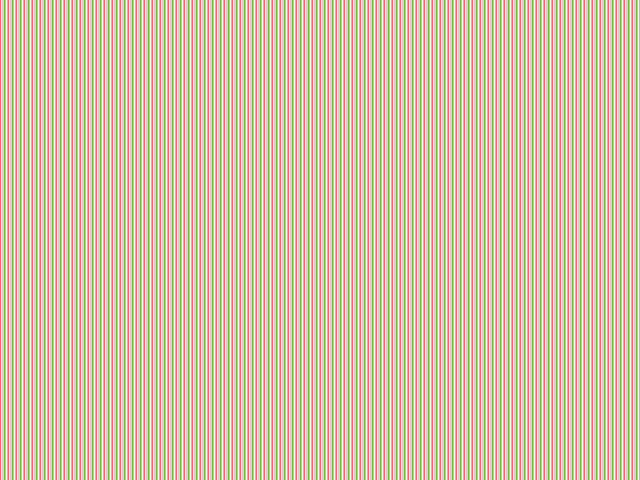

interactive(children=(IntSlider(value=24, description='index', max=49), RadioButtons(description='along', opti…

In [8]:
subvol_seg = subvol_gauss.binary_digitize(threshold='minimum')
subvol_seg = subvol_seg.invert_contrast()
subvol_seg.show_slice()

### Generate 3d tetragonal mesh

Meshes can be generated using the `Mesher3D` class. Meshing consists of two steps:

1. Contour finding (using the [`marching_cubes`](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.marching_cubes) function
2. Triangulation (using the [`tetgen`](https://tetgen.pyvista.org/) library)

`Mesher3D` requires a segmented image. `generate_contour()` wraps all domains of the image corresponding to that label. Here, 1 corresponds to the bulk (Si) material.

Meshing options are defined in the [tetgen documentation](http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual005.html#sec35). These can be specified using the `opts` parameter. The default options are `opts='-pAq1.2`:

- `-A`: Assigns attributes to tetrahedra in different regions.
- `-p`: Tetrahedralizes a piecewise linear complex (PLC).
- `-q`: Refines mesh (to improve mesh quality).

Also useful:

- `-a`: Applies a maximum tetrahedron volume constraint. Don't make `-a` too small, or the algorithm will take a very long time to complete. If this parameter is left out, the triangles will keep growing without limit.

In [9]:
%%time

from nanomesh import Mesher3D

mesher = Mesher3D(subvol_seg)
mesher.generate_contour()
mesh = mesher.tetrahedralize(opts='-pAq')

Wall time: 11 s


Tetrahedralization returns a `TetraMesh` dataclass that can be used for various operations, for example showing the result using `itkwidgets`:

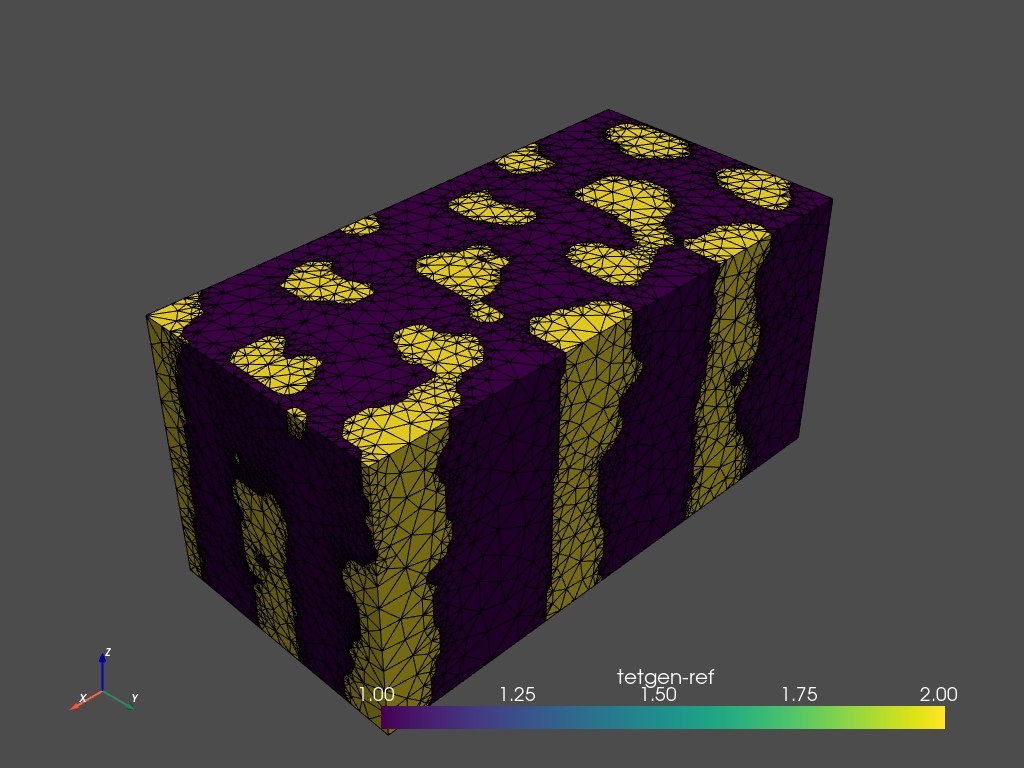

In [10]:
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

### Using region markers

By default, the region attributes are assigned automatically by `tetgen`. Tetrahedra in each enclosed region will be assigned a new label sequentially. 

Region markers are used to assign attributes to tetrahedra in different regions. After tetrahedralization, the region markers will 'flood' the regions up to the defined boundaries. The elements of the resulting mesh are marked according to the region they belong to (`tetras.metadata['tetgenRef']`.

You can view the existing region markers by looking at the `.region_markers` attribute on the contour.

In [11]:
mesher.contour.region_markers

RegionMarkerList(
    RegionMarker(label=1, point=(49, 17, 29), name='background', constraint=0),
    RegionMarker(label=2, point=(7, 14, 20), name='feature', constraint=0),
    RegionMarker(label=2, point=(7, 37, 20), name='feature', constraint=0),
    RegionMarker(label=2, point=(35, 36, 32), name='feature', constraint=0),
    RegionMarker(label=2, point=(26, 3, 39), name='feature', constraint=0),
    RegionMarker(label=1, point=(21.6, 48.6, 24.066666666666666), name='background', constraint=0),
    RegionMarker(label=2, point=(43, 12, 40), name='feature', constraint=0),
    RegionMarker(label=2, point=(70, 34, 35), name='feature', constraint=0),
    RegionMarker(label=1, point=(53, 23, 48), name='background', constraint=0),
    RegionMarker(label=1, point=(54, 23, 49), name='background', constraint=0),
    RegionMarker(label=2, point=(61, 2, 21), name='feature', constraint=0),
    RegionMarker(label=2, point=(78, 10, 32), name='feature', constraint=0),
    RegionMarker(label=2, poin

It is possible to set your own attributes using the `region_markers` parameter. These are a list of `RegionMarker` objects stored in a `RegionMarkerList` container. You can define your own, or you can use the methods on the `mesher.contour.region_markers` attribute.

For example, to relabel the pores sequentially:

In [12]:
mesher.contour.region_markers = mesher.contour.region_markers.label_sequentially(2, fmt_name='pore{}')
mesher.contour.region_markers

RegionMarkerList(
    RegionMarker(label=1, point=(49, 17, 29), name='background', constraint=0),
    RegionMarker(label=3, point=(7, 14, 20), name='pore3', constraint=0),
    RegionMarker(label=4, point=(7, 37, 20), name='pore4', constraint=0),
    RegionMarker(label=5, point=(35, 36, 32), name='pore5', constraint=0),
    RegionMarker(label=6, point=(26, 3, 39), name='pore6', constraint=0),
    RegionMarker(label=1, point=(21.6, 48.6, 24.066666666666666), name='background', constraint=0),
    RegionMarker(label=7, point=(43, 12, 40), name='pore7', constraint=0),
    RegionMarker(label=8, point=(70, 34, 35), name='pore8', constraint=0),
    RegionMarker(label=1, point=(53, 23, 48), name='background', constraint=0),
    RegionMarker(label=1, point=(54, 23, 49), name='background', constraint=0),
    RegionMarker(label=9, point=(61, 2, 21), name='pore9', constraint=0),
    RegionMarker(label=10, point=(78, 10, 32), name='pore10', constraint=0),
    RegionMarker(label=11, point=(81, 24, 34

Then re-run tetrahedralization.

In [13]:
%%time
import numpy as np

mesh = mesher.tetrahedralize(opts='-pAq')

for label in mesher.contour.region_markers.labels:
    num = np.sum(mesh.cell_data['tetgen:ref'] == label)
    print(f'{num} tetrahedra with attribute `{label}`')

0 tetrahedra with attribute `1`
0 tetrahedra with attribute `3`
0 tetrahedra with attribute `4`
0 tetrahedra with attribute `5`
0 tetrahedra with attribute `6`
0 tetrahedra with attribute `7`
0 tetrahedra with attribute `8`
0 tetrahedra with attribute `9`
0 tetrahedra with attribute `10`
0 tetrahedra with attribute `11`
0 tetrahedra with attribute `12`
0 tetrahedra with attribute `13`
0 tetrahedra with attribute `14`
0 tetrahedra with attribute `15`
Wall time: 11.2 s


Note that all connected regions have a different label now.

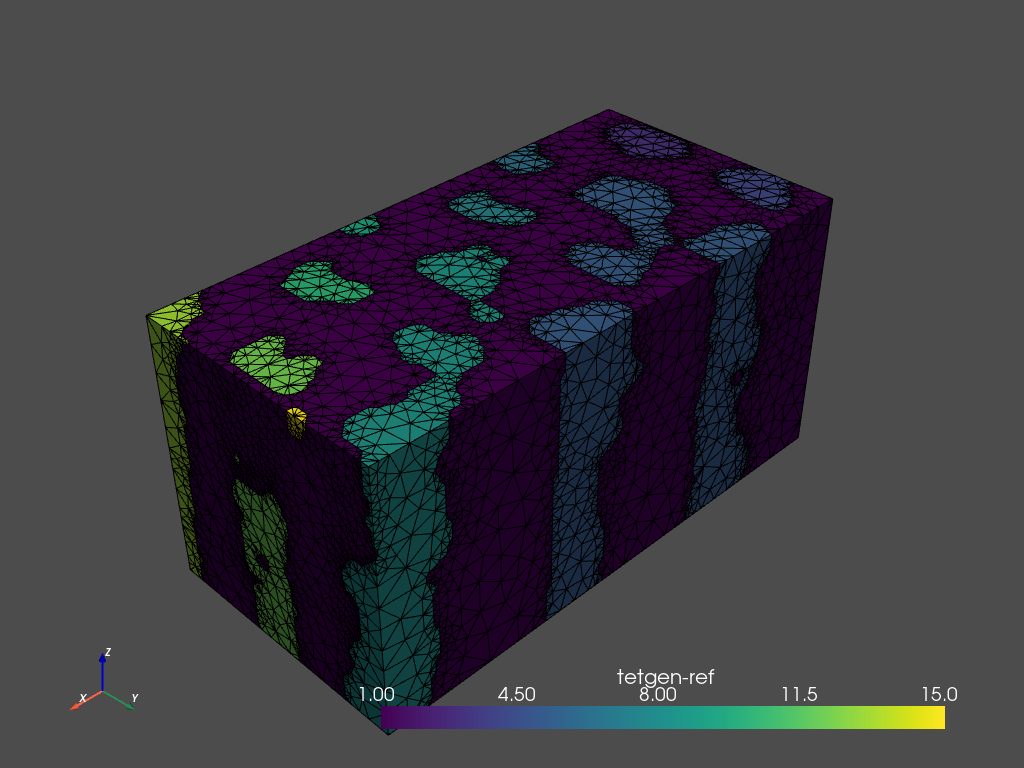

In [14]:
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

### Mesh evaluation

The mesh can be evaluated using the `metrics` module. This example shows how to calculate all metrics and plot them on a section through the generated mesh.

In [15]:
from nanomesh import metrics

tetra_mesh = mesh.get('tetra')

metrics_dict = metrics.calculate_all_metrics(tetra_mesh, inplace=True)
metrics_dict

{'area': array([-1., -1., -1., ..., -1., -1., -1.]),
 'aspect_frobenius': array([1.77763977, 1.44255904, 1.43086745, ..., 1.19608599, 1.2380057 ,
        1.67189633]),
 'aspect_ratio': array([2.1873106 , 1.96937792, 1.89451942, ..., 1.49284367, 1.62185301,
        2.05904029]),
 'condition': array([1.61963364, 1.39541944, 1.42715219, ..., 1.19508538, 1.22113615,
        1.64930174]),
 'max_angle': array([-1., -1., -1., ..., -1., -1., -1.]),
 'min_angle': array([57.06893507, 46.8503146 , 70.18711125, ..., 46.2518936 ,
        50.67266078, 43.69610601]),
 'radius_ratio': array([1.80458403, 1.69912633, 1.55159124, ..., 1.24603806, 1.33411248,
        1.69710314]),
 'scaled_jacobian': array([0.19141559, 0.3948554 , 0.34433982, ..., 0.55473512, 0.55476824,
        0.22458057]),
 'shape': array([0.56254367, 0.69321253, 0.69887675, ..., 0.83606029, 0.80775073,
        0.59812321]),
 'relative_size_squared': array([0., 0., 0., ..., 0., 0., 0.]),
 'shape_and_size': array([0., 0., 0., ..., 0., 0

Using the `.plot_submesh()` method, any array that is present in the metadata can be plotted. `plot_submesh()` is flexible, in that it can show a slice through the mesh as defined using `index`, `along`, and `invert`. Extra keyword arguments, such as `show_edges` and `lighting` are passed on to [`Plotter.add_mesh()`](https://docs.pyvista.org/api/plotting/_autosummary/pyvista.Plotter.add_mesh.html?highlight=add_mesh).

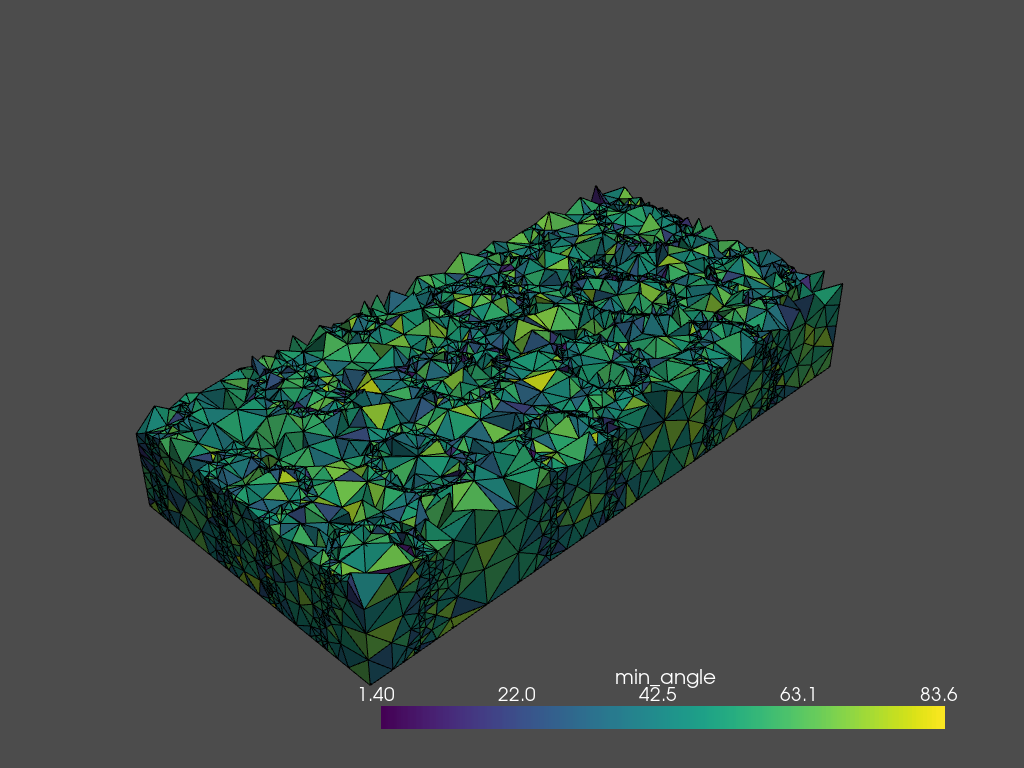

In [16]:
tetra_mesh.plot_submesh(
    along='x',
    index=15,
    scalars='min_angle', 
    show_edges=True, 
    lighting=True, 
    backend='static',
)

### Interoperability

The `TetraMesh` object can also be used to convert to various other library formats, such as:

- [`trimesh.open3d`](http://www.open3d.org/docs/release/python_api/open3d.geometry.TetraMesh.html#open3d.geometry.TetraMesh)
- [`pyvista.UnstructuredGrid`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)
- [`meshio.Mesh`](https://docs.pyvista.org/examples/00-load/create-unstructured-surface.html)

To save the data, use the `.write` method. This is essentially a very thin wrapper around `meshio`, equivalent to `meshio_mesh.write(...)`.

In [17]:
tetra_mesh.write('volume_mesh.msh', file_format='gmsh22', binary=False)

Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.